In [1]:
# Importer les bibliothèques dont on a besoin pour le projet
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Pour nettoyer le texte
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

# Pour les modèles de machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Pour vérifier si notre modèle marche bien
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Pour sauvegarder notre modèle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Télécharger ce qu'il faut pour NLTK
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

# Faire des beaux graphiques
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Tous les imports sont faits!")

Tous les imports sont faits!


In [2]:
# Charger le dataset IMDB
print("Chargement du dataset IMDB:")
print("-"*100)

df = pd.read_csv('dataset/IMDBDataset.csv')

# Afficher des infos sur les données
print(f"\nNombre de lignes et colonnes: {df.shape}")
print(f"Noms des colonnes: {df.columns.tolist()}")




Chargement du dataset IMDB:
----------------------------------------------------------------------------------------------------

Nombre de lignes et colonnes: (50000, 2)
Noms des colonnes: ['review', 'sentiment']


In [3]:
print(f"\nLes 5 premières lignes:")
df.head(5)



Les 5 premières lignes:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Fonction pour nettoyer le texte
def nettoyer_texte(texte):
    # Si ce n'est pas du texte, retourner vide
    if not isinstance(texte, str):
        return ""
    
    # Mettre en minuscules
    texte = texte.lower()
    
    # Enlever les balises HTML
    texte = re.sub(r'<.*?>', '', texte)
    
    # Enlever les URLs
    texte = re.sub(r'http\S+|www\S+|https\S+', '', texte)
    
    # Enlever les caractères spéciaux et chiffres
    texte = re.sub(r'[^a-zA-Z\s]', '', texte)
    
    # Enlever les espaces en trop
    texte = re.sub(r'\s+', ' ', texte).strip()
    
    return texte


# Nettoyer les données
print("_"*100)
print(" Nettoyage du texte:")
print("_"*100)

# Trouver la colonne du texte et du sentiment
colonne_texte = None
for col in df.columns:
    if 'review' in col.lower() or 'text' in col.lower():
        colonne_texte = col
        break

colonne_sentiment = None
for col in df.columns:
    if 'sentiment' in col.lower() or 'label' in col.lower():
        colonne_sentiment = col
        break

# Vérifier qu'on a trouvé les colonnes
if colonne_texte and colonne_sentiment:
    print(f"Colonne texte: {colonne_texte}")
    print(f"Colonne sentiment: {colonne_sentiment}")
    
    # Enlever les doublons
    nb_avant = len(df)
    df = df.drop_duplicates(subset=[colonne_texte], keep='first')
    nb_doublons = nb_avant - len(df)
    print(f"\nDoublons enlevés: {nb_doublons}")
    
    # Enlever les valeurs manquantes
    df = df.dropna(subset=[colonne_texte, colonne_sentiment])
    print(f"Valeurs manquantes enlevées")
    
    # Nettoyer le texte
    print(f"Nettoyage de {len(df)} avis...")
    df['texte_propre'] = df[colonne_texte].apply(nettoyer_texte)
    
    # Enlever les avis vides
    df = df[df['texte_propre'].str.len() > 0]
    print(f"Nombre final de lignes: {df.shape}")
    
    print(f"\nDistribution des sentiments:")
    print(df[colonne_sentiment].value_counts())
else:
    print("Impossible de trouver les colonnes!")

____________________________________________________________________________________________________
 Nettoyage du texte:
____________________________________________________________________________________________________
Colonne texte: review
Colonne sentiment: sentiment

Doublons enlevés: 418
Valeurs manquantes enlevées
Nettoyage de 49582 avis...
Nombre final de lignes: (49582, 3)

Distribution des sentiments:
sentiment
positive    24884
negative    24698
Name: count, dtype: int64


____________________________________________________________________________________________________
  Analyse de la fréquence des mots:
____________________________________________________________________________________________________

Nombre de mots uniques: 214430
Nombre total de mots: 11174761

Top 20 mots les plus fréquents:
  the: 645856
  and: 317120
  a: 317056
  of: 286019
  to: 264308
  is: 208627
  in: 181811
  it: 150221
  i: 144352
  this: 144347
  that: 134804
  was: 94397
  as: 89400
  with: 85904
  for: 85509
  movie: 82915
  but: 79727
  film: 73989
  on: 65801
  not: 59043


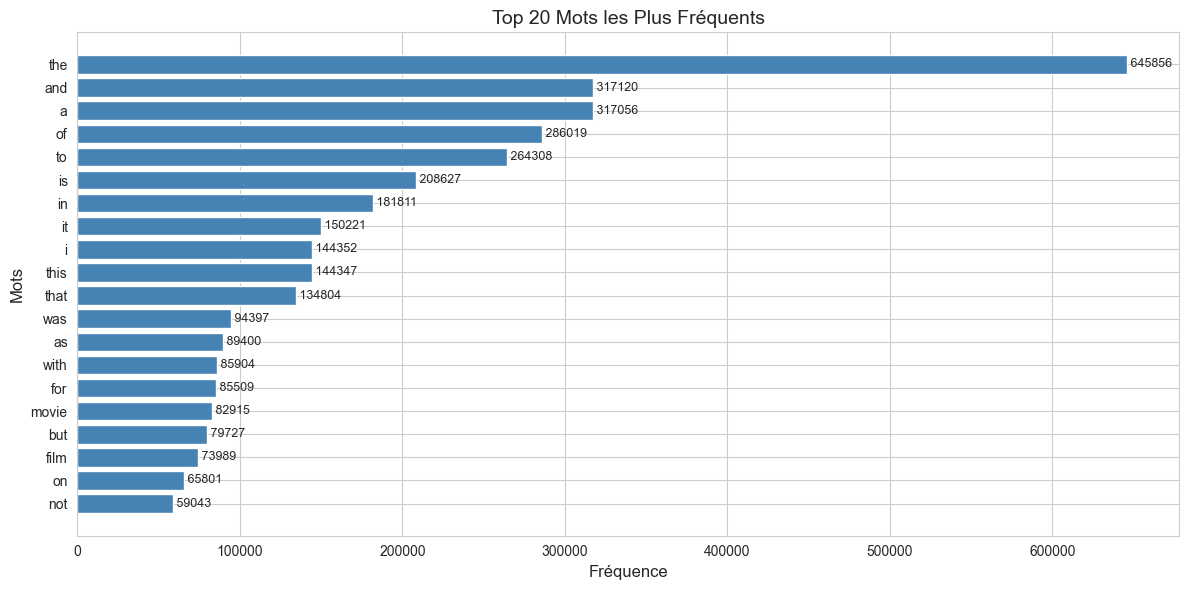


Graphique sauvegardé comme 'word_frequency.png'


In [5]:
# Analyse de la fréquence des mots
print("_"*100)
print("  Analyse de la fréquence des mots:")
print("_"*100)

# Récupérer tous les mots
tous_les_mots = []
for texte in df['texte_propre']:
    mots = texte.split()
    tous_les_mots.extend(mots)

# Compter les mots
freq_mots = Counter(tous_les_mots)
top_20 = freq_mots.most_common(20)

print(f"\nNombre de mots uniques: {len(freq_mots)}")
print(f"Nombre total de mots: {len(tous_les_mots)}")
print(f"\nTop 20 mots les plus fréquents:")
for mot, count in top_20:
    print(f"  {mot}: {count}")

# Faire un graphique
fig, ax = plt.subplots(figsize=(12, 6))
mots = [w[0] for w in top_20]
counts = [w[1] for w in top_20]

ax.barh(mots, counts, color='steelblue')
ax.set_xlabel('Fréquence', fontsize=12)
ax.set_ylabel('Mots', fontsize=12)
ax.set_title('Top 20 Mots les Plus Fréquents', fontsize=14)
ax.invert_yaxis()

# Ajouter les nombres sur les barres
for i, count in enumerate(counts):
    ax.text(count, i, f' {count}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('word_frequency.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nGraphique sauvegardé comme 'word_frequency.png'")

In [6]:
# Statistiques sur les données
print("_"*100)
print("   STATISTIQUES DES DONNEES:")
print("_"*100)

print(f"\nRésumé du dataset:")
print(f"  Nombre d'avis: {len(df)}")
print(f"  Nombre de colonnes: {len(df.columns)}")

# Calculer la longueur du texte et le nombre de mots
df['longueur_texte'] = df['texte_propre'].str.len()
df['nb_mots'] = df['texte_propre'].str.split().str.len()

print(f"\nStatistiques sur la longueur (caractères):")
print(f"  Moyenne: {df['longueur_texte'].mean():.2f}")
print(f"  Médiane: {df['longueur_texte'].median():.2f}")
print(f"  Écart-type: {df['longueur_texte'].std():.2f}")
print(f"  Min: {df['longueur_texte'].min()}")
print(f"  Max: {df['longueur_texte'].max()}")

print(f"\nStatistiques sur le nombre de mots:")
print(f"  Moyenne: {df['nb_mots'].mean():.2f}")
print(f"  Médiane: {df['nb_mots'].median():.2f}")
print(f"  Écart-type: {df['nb_mots'].std():.2f}")
print(f"  Min: {df['nb_mots'].min()}")
print(f"  Max: {df['nb_mots'].max()}")

print(f"\nDistribution des sentiments:")
print(df[colonne_sentiment].value_counts())

print(f"\nPourcentage de chaque sentiment:")
print(df[colonne_sentiment].value_counts(normalize=True))

____________________________________________________________________________________________________
   STATISTIQUES DES DONNEES:
____________________________________________________________________________________________________

Résumé du dataset:
  Nombre d'avis: 49582
  Nombre de colonnes: 3

Statistiques sur la longueur (caractères):
  Moyenne: 1240.32
  Médiane: 920.00
  Écart-type: 938.84
  Min: 30
  Max: 13262

Statistiques sur le nombre de mots:
  Moyenne: 225.38
  Médiane: 169.00
  Écart-type: 167.13
  Min: 4
  Max: 2441

Distribution des sentiments:
sentiment
positive    24884
negative    24698
Name: count, dtype: int64

Pourcentage de chaque sentiment:
sentiment
positive    0.501876
negative    0.498124
Name: proportion, dtype: float64


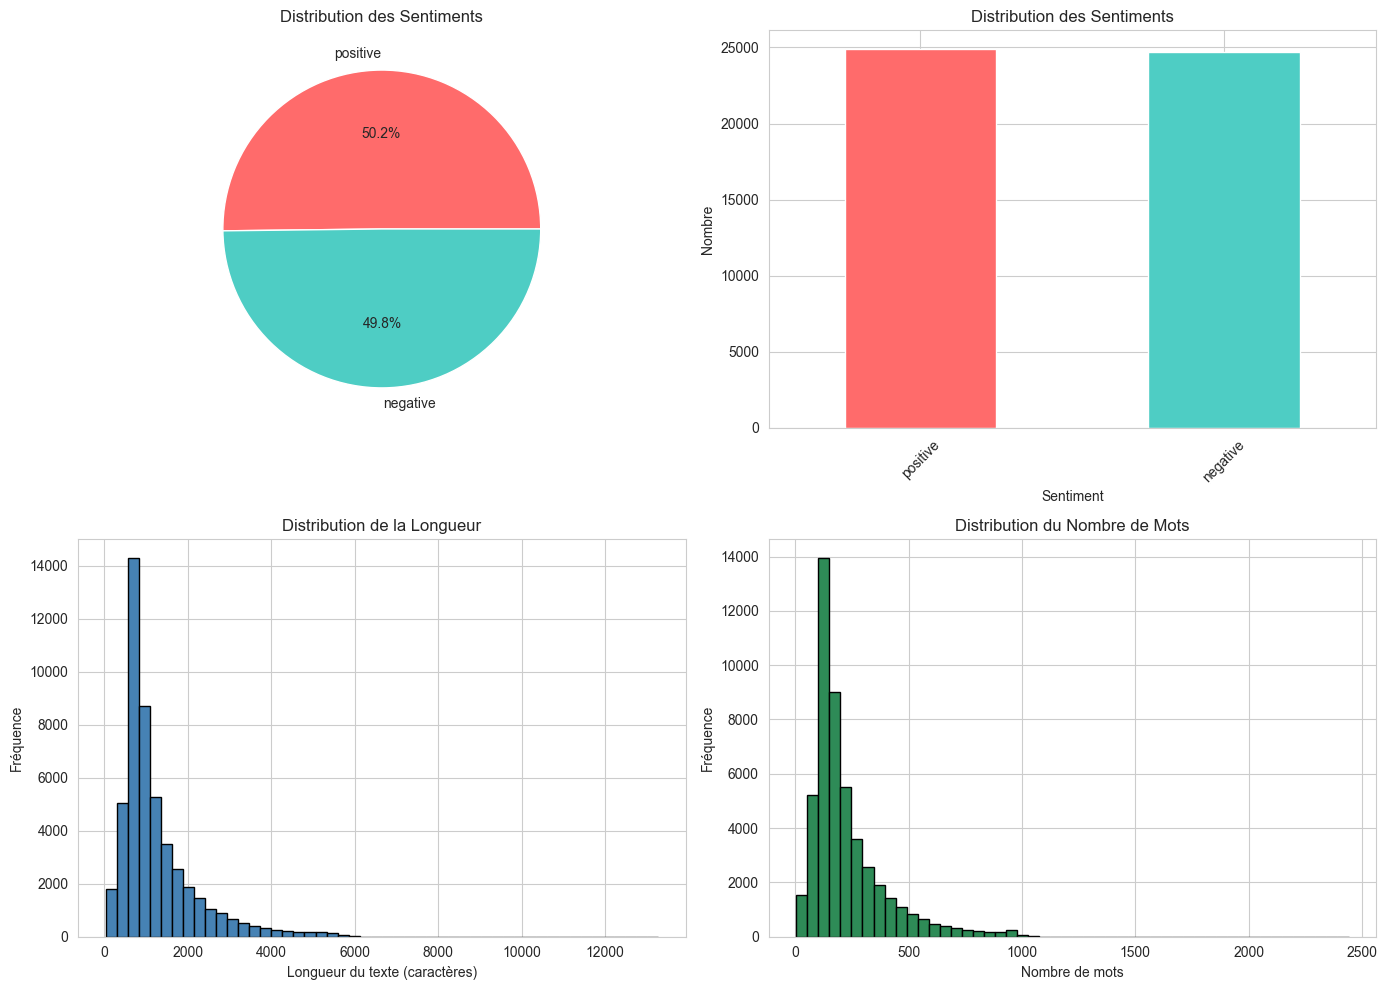

Graphique sauvegardé comme 'eda_overview.png'


In [7]:
# Visualisation des données
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Camembert de la distribution des sentiments
distribution = df[colonne_sentiment].value_counts()
axes[0, 0].pie(distribution.values, labels=distribution.index, autopct='%1.1f%%',
              colors=['#FF6B6B', '#4ECDC4'])
axes[0, 0].set_title('Distribution des Sentiments', fontsize=12)

# 2. Graphique en barres
distribution.plot(kind='bar', ax=axes[0, 1], color=['#FF6B6B', '#4ECDC4'])
axes[0, 1].set_title('Distribution des Sentiments', fontsize=12)
axes[0, 1].set_xlabel('Sentiment')
axes[0, 1].set_ylabel('Nombre')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Longueur des textes
axes[1, 0].hist(df['longueur_texte'], bins=50, color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Longueur du texte (caractères)')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution de la Longueur', fontsize=12)

# 4. Nombre de mots
axes[1, 1].hist(df['nb_mots'], bins=50, color='seagreen', edgecolor='black')
axes[1, 1].set_xlabel('Nombre de mots')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].set_title('Distribution du Nombre de Mots', fontsize=12)

plt.tight_layout()
plt.savefig('eda_overview.png', dpi=100, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé comme 'eda_overview.png'")

____________________________________________________________________________________________________
  Création des nuages de mots:
____________________________________________________________________________________________________


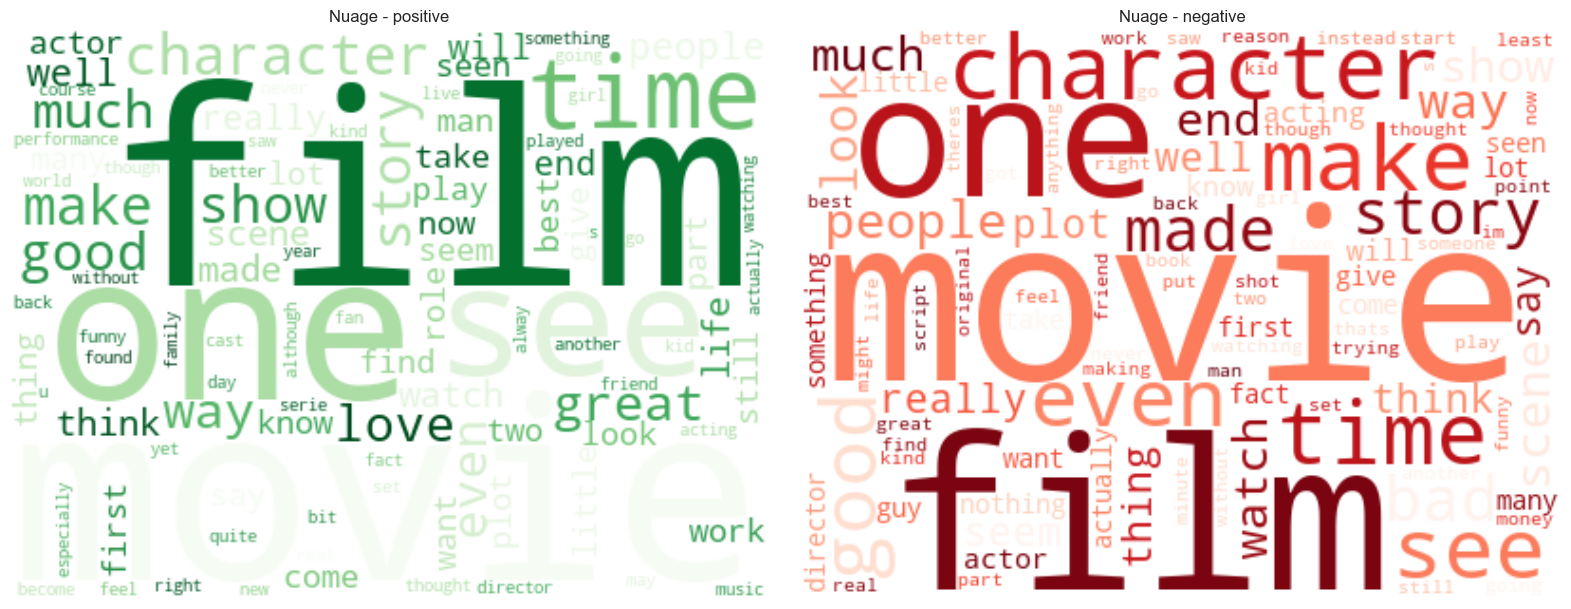


Nuage de mots sauvegardé comme 'wordcloud_sentiment.png'


In [8]:
# Nuages de mots pour chaque sentiment
print("_"*100)
print("  Création des nuages de mots:")
print("_"*100)

sentiments_uniques = df[colonne_sentiment].unique()
fig, axes = plt.subplots(1, len(sentiments_uniques), figsize=(16, 6))

# S'il n'y a qu'un seul sentiment, faire un array
if len(sentiments_uniques) == 1:
    axes = [axes]

couleurs = ['Greens', 'Reds', 'Blues', 'Purples']

for i, sentiment in enumerate(sentiments_uniques):
    # Récupérer le texte pour ce sentiment
    texte_sentiment = ' '.join(df[df[colonne_sentiment] == sentiment]['texte_propre'].values)
    
    if len(texte_sentiment) > 0:
        # Créer le nuage de mots
        nuage = WordCloud(width=400, height=300, background_color='white',
                         colormap=couleurs[i], max_words=100).generate(texte_sentiment)
        
        # Afficher
        axes[i].imshow(nuage, interpolation='bilinear')
        axes[i].set_title(f'Nuage - {sentiment}', fontsize=12)
        axes[i].axis('off')

plt.tight_layout()
plt.savefig('wordcloud_sentiment.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nNuage de mots sauvegardé comme 'wordcloud_sentiment.png'")

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
# Préparer les données pour l'entraînement
print("_"*100)
print("\n Préparation des données:")
print("_"*100)

# Encoder les sentiments (0 et 1)
encodeur = LabelEncoder()
y = np.array(encodeur.fit_transform(df[colonne_sentiment]))
X = df['texte_propre'].values

print(f"Nombre de textes: {X.shape[0]}")
print(f"Nombre de labels: {y.shape[0]}")
print(f"Classes: {encodeur.classes_}")

# Diviser en train et test (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTaille de l'entraînement: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Taille du test: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

____________________________________________________________________________________________________

 Préparation des données:
____________________________________________________________________________________________________
Nombre de textes: 49582
Nombre de labels: 49582
Classes: ['negative' 'positive']

Taille de l'entraînement: 39665 (80.0%)
Taille du test: 9917 (20.0%)


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Créer les features pour les modèles
print("-"*100)
print("\n Création des features:")
print("-"*100)

# 1. TF-IDF
print("TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    stop_words='english'
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"  Forme: {X_train_tfidf.shape}")
print(f"  Nombre de mots: {len(tfidf.vocabulary_)}")

# 2. CountVectorizer
print("\nCountVectorizer...")
cv = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    stop_words='english'
)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
print(f"  Forme: {X_train_cv.shape}")

# 3. Word2Vec
print("\nWord2Vec...")
try:
    from gensim.models import Word2Vec
    
    # Diviser le texte en mots
    phrases = [texte.split() for texte in X_train]
    
    # Entraîner Word2Vec
    modele_w2v = Word2Vec(phrases, vector_size=100, window=5, min_count=2, workers=4)
    
    def obtenir_vecteur_w2v(texte, modele, taille=100):
        mots = texte.split()
        vecteurs = [modele.wv[mot] for mot in mots if mot in modele.wv]
        if len(vecteurs) == 0:
            return np.zeros(taille)
        return np.mean(vecteurs, axis=0)
    
    X_train_w2v = np.array([obtenir_vecteur_w2v(texte, modele_w2v) for texte in X_train])
    X_test_w2v = np.array([obtenir_vecteur_w2v(texte, modele_w2v) for texte in X_test])
    print(f"  Forme: {X_train_w2v.shape}")
    
except ImportError:
    print("  Word2Vec pas disponible - installer gensim: pip install gensim")
    X_train_w2v = None
    X_test_w2v = None
    modele_w2v = None

print("\nFeatures créées!")

----------------------------------------------------------------------------------------------------

 Création des features:
----------------------------------------------------------------------------------------------------
TF-IDF...
  Forme: (39665, 5000)
  Nombre de mots: 5000

CountVectorizer...
  Forme: (39665, 5000)

Word2Vec...
  Forme: (39665, 100)

Features créées!


In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Entraînement de 6 modèles - version RAPIDE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

print("\n" + "_"*100)
print(" Entraînement des modèles:")
print("_"*100)

# 6 modèles 
modeles = [
    {
        'nom': 'Logistic Regression',
        'model': LogisticRegression(max_iter=100, random_state=42, solver='lbfgs')
    },
    {
        'nom': 'Random Forest',
        'model': RandomForestClassifier(n_estimators=50, random_state=42, max_depth=15)
    },
    {
        'nom': 'SVM (SGD - Rapide)',
        'model': SGDClassifier(loss='hinge', max_iter=500, random_state=42)
    },
    {
        'nom': 'Naive Bayes',
        'model': MultinomialNB(alpha=1.0)
    },
    {
        'nom': 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42, max_depth=15)
    },
    {
        'nom': 'Gradient Boosting',
        'model': GradientBoostingClassifier(n_estimators=50, random_state=42, max_depth=5)
    }
]

# Stocker les résultats
modeles_entraines = {}
metriques_cv = {}
metriques_finales = {}

# Cross-validation rapide (3 folds)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for config in modeles:
    nom = config['nom']
    model = config['model']
    print(f"\n{nom}:")
    print("-" * 50)
    
    try:
        # Entraîner le modèle
        print(f"  Entraînement en cours")
        model.fit(X_train_tfidf, y_train)
        
        # Cross-validation
        scores_cv = cross_val_score(model, X_train_tfidf, y_train, 
                                    cv=kfold, scoring='f1_weighted')
        metriques_cv[nom] = {
            'moyenne': scores_cv.mean(),
            'std': scores_cv.std(),
            'scores': scores_cv
        }
        
        # Prédictions
        y_pred = model.predict(X_test_tfidf)
        
        # Gérer predict_proba et decision_function
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test_tfidf)
        
        # Métriques
        metriques = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'cv_f1_mean': metriques_cv[nom]['moyenne'],
            'cv_f1_std': metriques_cv[nom]['std']
        }
        
        metriques_finales[nom] = metriques
        modeles_entraines[nom] = model
        
        # Afficher les résultats
        print(f"  Accuracy: {metriques['accuracy']:.4f}")
        print(f"  F1 Score: {metriques['f1']:.4f}")
        print(f"  ROC-AUC: {metriques['roc_auc']:.4f}")
        print(f"  CV F1: {metriques['cv_f1_mean']:.4f}±{metriques['cv_f1_std']:.4f}")
        
    except Exception as e:
        print(f"  Erreur: {str(e)}")

print(f"\n{len(modeles_entraines)} modèles entraînés!")
print("="*70)


____________________________________________________________________________________________________
 Entraînement des modèles:
____________________________________________________________________________________________________

Logistic Regression:
--------------------------------------------------
  Entraînement en cours...
  Accuracy: 0.8837
  F1 Score: 0.8837
  ROC-AUC: 0.9552
  CV F1: 0.8796±0.0016

Random Forest:
--------------------------------------------------
  Entraînement en cours...
  Accuracy: 0.8140
  F1 Score: 0.8132
  ROC-AUC: 0.9019
  CV F1: 0.8118±0.0018

SVM (SGD - Rapide):
--------------------------------------------------
  Entraînement en cours...
  Accuracy: 0.8811
  F1 Score: 0.8811
  ROC-AUC: 0.9539
  CV F1: 0.8794±0.0025

Naive Bayes:
--------------------------------------------------
  Entraînement en cours...
  Accuracy: 0.8541
  F1 Score: 0.8541
  ROC-AUC: 0.9305
  CV F1: 0.8520±0.0011

Decision Tree:
--------------------------------------------------
  

____________________________________________________________________________________________________

Comparaison des Résultats
____________________________________________________________________________________________________

                     accuracy  precision  recall      f1  roc_auc  cv_f1_mean  cv_f1_std
Logistic Regression    0.8837     0.8840  0.8837  0.8837   0.9552      0.8796     0.0016
Random Forest          0.8140     0.8185  0.8140  0.8132   0.9019      0.8118     0.0018
SVM (SGD - Rapide)     0.8811     0.8814  0.8811  0.8811   0.9539      0.8794     0.0025
Naive Bayes            0.8541     0.8543  0.8541  0.8541   0.9305      0.8520     0.0011
Decision Tree          0.7335     0.7422  0.7335  0.7309   0.7806      0.7233     0.0020
Gradient Boosting      0.7934     0.7994  0.7934  0.7923   0.8832      0.7885     0.0008


Meilleur modèle par métrique:
----------------------------------------
Accuracy:  Logistic Regression (0.8837)
F1 Score:  Logistic Regression (0.

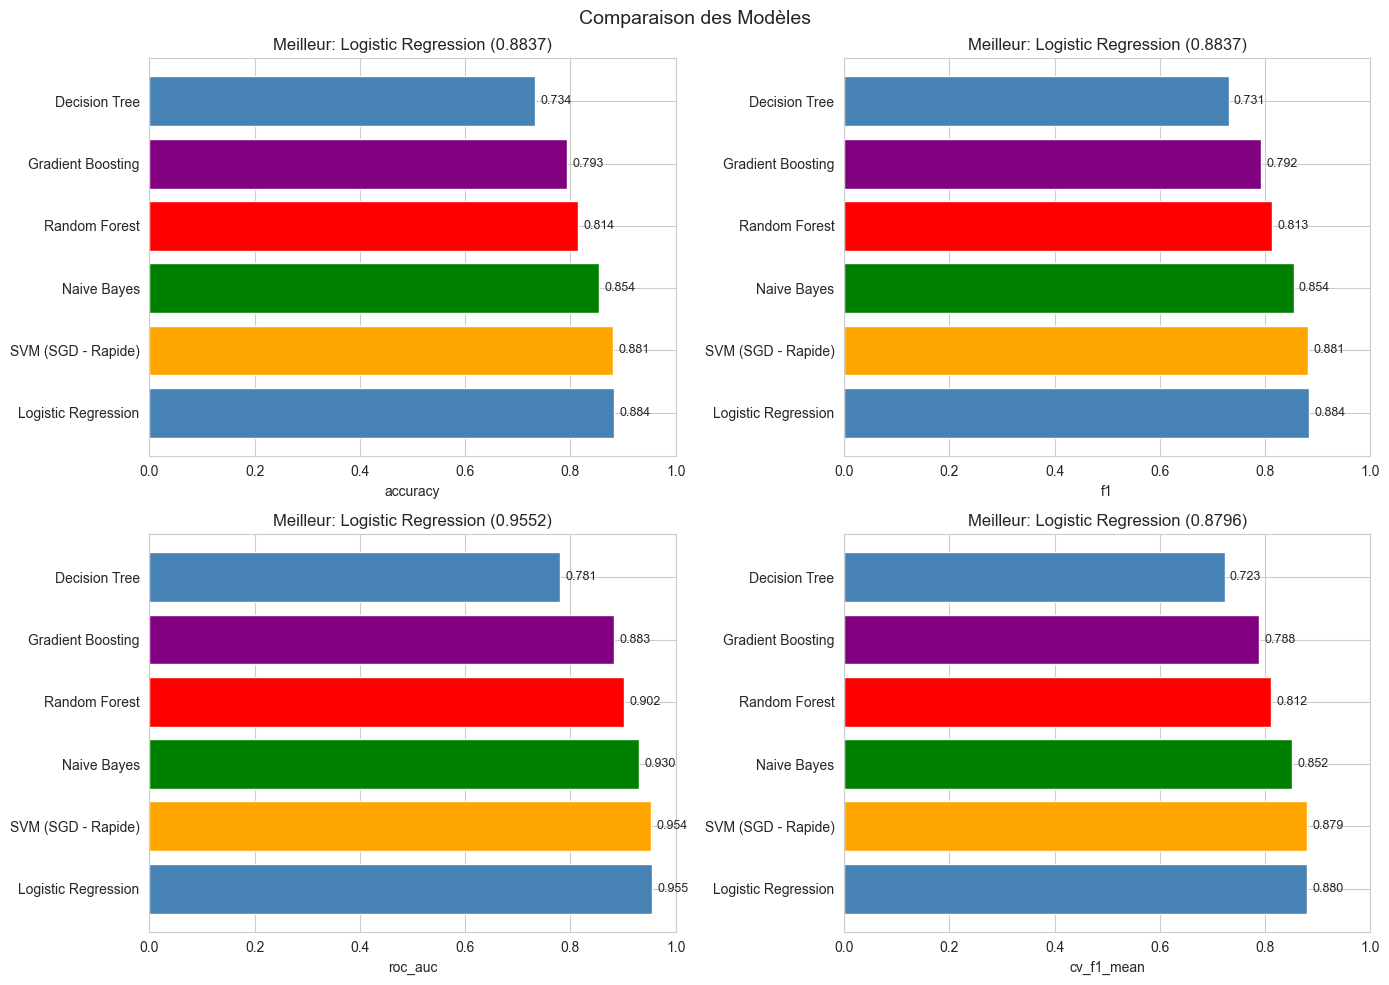


Comparaison terminée!


In [20]:
# Comparer les résultats des modèles
print("_"*100)
print("\nComparaison des Résultats")
print("_"*100)

# Créer un tableau avec toutes les métriques
tableau_metriques = pd.DataFrame(metriques_finales).T
tableau_metriques = tableau_metriques.round(4)

print("\n" + tableau_metriques.to_string())

# Trouver les meilleurs modèles
print("\n" + "="*70)
print("\nMeilleur modèle par métrique:")
print("-" * 40)
print(f"Accuracy:  {tableau_metriques['accuracy'].idxmax()} ({tableau_metriques['accuracy'].max():.4f})")
print(f"F1 Score:  {tableau_metriques['f1'].idxmax()} ({tableau_metriques['f1'].max():.4f})")
print(f"ROC-AUC:   {tableau_metriques['roc_auc'].idxmax()} ({tableau_metriques['roc_auc'].max():.4f})")
print(f"CV F1:     {tableau_metriques['cv_f1_mean'].idxmax()} ({tableau_metriques['cv_f1_mean'].max():.4f})")

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparaison des Modèles', fontsize=14)

metriques_a_afficher = ['accuracy', 'f1', 'roc_auc', 'cv_f1_mean']

for idx, metrique in enumerate(metriques_a_afficher):
    ax = axes[idx // 2, idx % 2]
    valeurs = tableau_metriques[metrique].sort_values(ascending=False)
    couleurs = ['steelblue', 'orange', 'green', 'red', 'purple'][:len(valeurs)]
    
    ax.barh(valeurs.index, valeurs.values, color=couleurs)
    ax.set_xlabel(metrique)
    ax.set_title(f'Meilleur: {valeurs.idxmax()} ({valeurs.max():.4f})')
    ax.set_xlim([0, 1])
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(valeurs.values):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nComparaison terminée!")


Courbes d'évaluation...


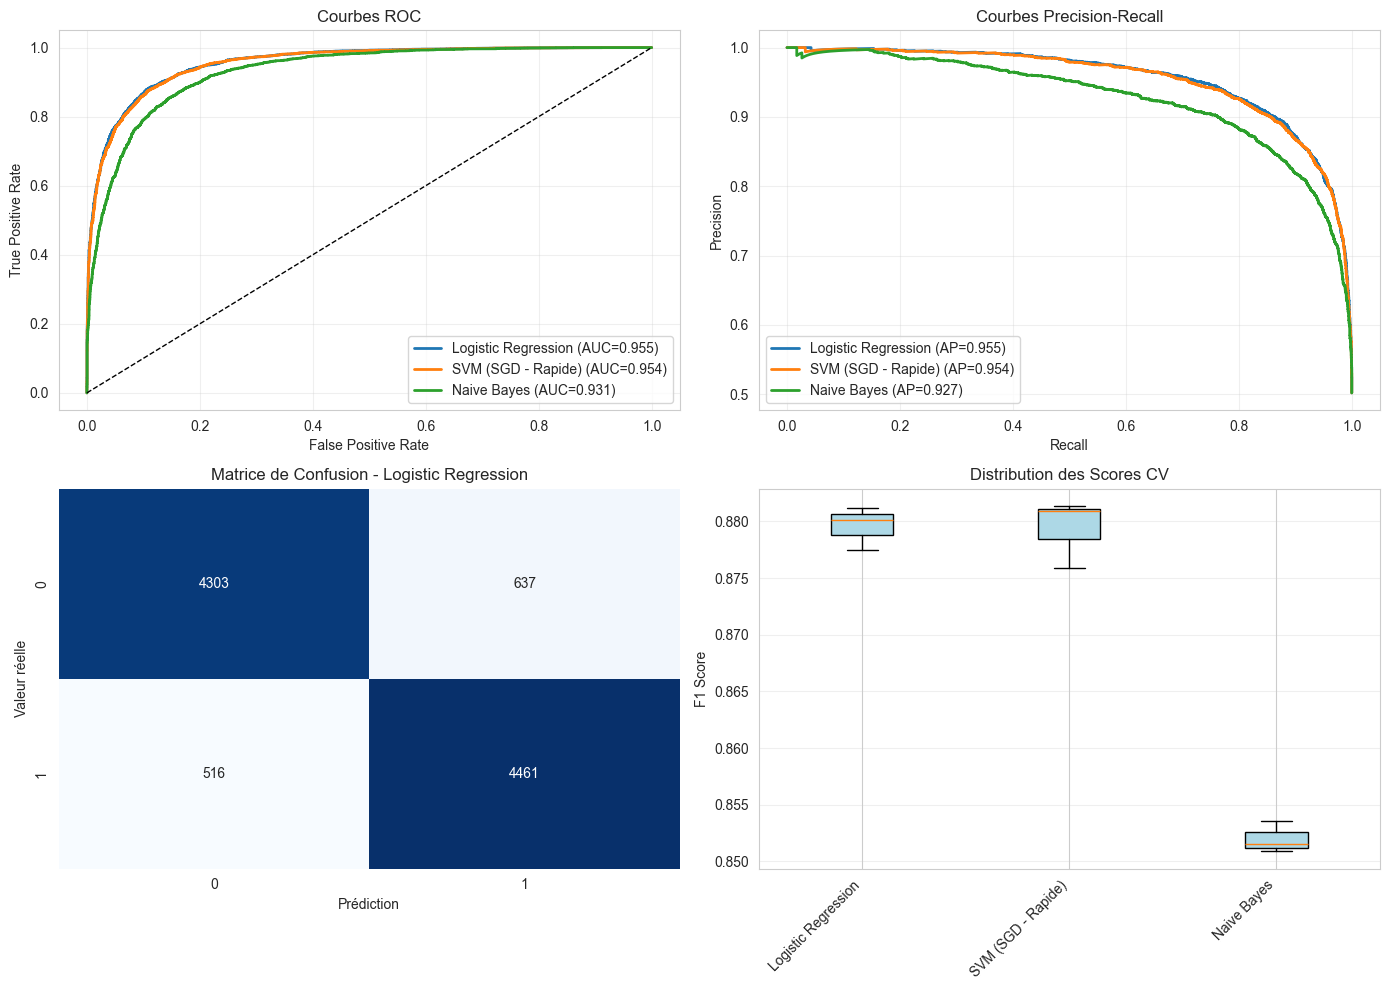


Courbes d'évaluation générées!


In [21]:
# Courbes d'évaluation avancées
print("\nCourbes d'évaluation...")
print("="*70)

from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import confusion_matrix

# Prendre les 3 meilleurs modèles
top_3 = sorted(metriques_finales.items(), 
               key=lambda x: x[1]['f1'], 
               reverse=True)[:3]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Courbes ROC
ax1 = axes[0, 0]
for nom_model, metriques in top_3:
    model = modeles_entraines[nom_model]
    
    try:
        y_proba = model.predict_proba(X_test_tfidf)[:, 1]
    except:
        y_proba = model.decision_function(X_test_tfidf)
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    score_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{nom_model} (AUC={score_auc:.3f})', lw=2)

ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Courbes ROC')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Courbes Precision-Recall
ax2 = axes[0, 1]
for nom_model, metriques in top_3:
    model = modeles_entraines[nom_model]
    
    try:
        y_proba = model.predict_proba(X_test_tfidf)[:, 1]
    except:
        y_proba = model.decision_function(X_test_tfidf)
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, label=f'{nom_model} (AP={pr_auc:.3f})', lw=2)

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Courbes Precision-Recall')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Matrice de confusion
ax3 = axes[1, 0]
meilleur_model_nom, _ = top_3[0]
meilleur_model = modeles_entraines[meilleur_model_nom]
y_pred = meilleur_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar=False)
ax3.set_title(f'Matrice de Confusion - {meilleur_model_nom}')
ax3.set_ylabel('Valeur réelle')
ax3.set_xlabel('Prédiction')

# 4. Distribution des scores CV
ax4 = axes[1, 1]
donnees_cv = [metriques_cv[nom]['scores'] for nom, _ in top_3]
bp = ax4.boxplot(donnees_cv, labels=[nom for nom, _ in top_3], patch_artist=True)
for box in bp['boxes']:
    box.set_facecolor('lightblue')
ax4.set_ylabel('F1 Score')
ax4.set_title('Distribution des Scores CV')
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\nCourbes d'évaluation générées!")

In [22]:
# Sauvegarder les modèles
print("\nSauvegarde des modèles...")
print("="*70)

import os
import json
import joblib
from datetime import datetime

# Créer un dossier pour les modèles
dossier_modeles = 'models'
os.makedirs(dossier_modeles, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Créer un registre des modèles
registre = {
    'timestamp': timestamp,
    'nombre_donnees': len(X_train) + len(X_test),
    'taille_train': len(X_train),
    'taille_test': len(X_test),
    'type_feature': 'TF-IDF',
    'modeles': {}
}

# Sauvegarder le vectorizer TF-IDF
chemin_tfidf = os.path.join(dossier_modeles, f'tfidf_{timestamp}.pkl')
joblib.dump(tfidf, chemin_tfidf)
registre['chemin_vectorizer'] = chemin_tfidf
print(f"TF-IDF sauvegardé: {chemin_tfidf}")

# Sauvegarder tous les modèles
for nom_model, model in modeles_entraines.items():
    # Créer le nom du fichier
    fichier = f"{nom_model.lower().replace(' ', '_')}_{timestamp}.pkl"
    chemin = os.path.join(dossier_modeles, fichier)
    
    # Sauvegarder le modèle
    joblib.dump(model, chemin)
    
    # Récupérer les métriques
    metriques = metriques_finales.get(nom_model, {})
    
    # Ajouter au registre
    registre['modeles'][nom_model] = {
        'chemin': chemin,
        'fichier': fichier,
        'type': type(model).__name__,
        'accuracy': float(metriques.get('accuracy', 0)),
        'f1': float(metriques.get('f1', 0)),
        'roc_auc': float(metriques.get('roc_auc', 0)),
        'cv_f1_mean': float(metriques.get('cv_f1_mean', 0)),
        'cv_f1_std': float(metriques.get('cv_f1_std', 0)),
        'date': timestamp
    }
    
    print(f"{nom_model} sauvegardé: {chemin}")

# Sauvegarder le registre en JSON
chemin_registre = os.path.join(dossier_modeles, f'registre_{timestamp}.json')
with open(chemin_registre, 'w') as f:
    json.dump(registre, f, indent=2)
print(f"\nRegistre sauvegardé: {chemin_registre}")

# Sauvegarder le CountVectorizer si disponible
if 'cv' in locals():
    chemin_cv = os.path.join(dossier_modeles, f'count_vectorizer_{timestamp}.pkl')
    joblib.dump(cv, chemin_cv)
    print(f"CountVectorizer sauvegardé: {chemin_cv}")

print("\nTous les modèles sont sauvegardés!")


Sauvegarde des modèles...
TF-IDF sauvegardé: models\tfidf_20251210_051134.pkl
Logistic Regression sauvegardé: models\logistic_regression_20251210_051134.pkl
Random Forest sauvegardé: models\random_forest_20251210_051134.pkl
SVM (SGD - Rapide) sauvegardé: models\svm_(sgd_-_rapide)_20251210_051134.pkl
Naive Bayes sauvegardé: models\naive_bayes_20251210_051134.pkl
Decision Tree sauvegardé: models\decision_tree_20251210_051134.pkl
Gradient Boosting sauvegardé: models\gradient_boosting_20251210_051134.pkl

Registre sauvegardé: models\registre_20251210_051134.json
CountVectorizer sauvegardé: models\count_vectorizer_20251210_051134.pkl

Tous les modèles sont sauvegardés!


In [24]:
# Charger un modèle et faire des prédictions
print("\nChargement et Prédictions")
print("="*70)

import os
import json
import glob
import joblib

# Trouver le dernier registre
dossier_modeles = 'models'
fichiers_registre = sorted(glob.glob(os.path.join(dossier_modeles, 'registre_*.json')))

if fichiers_registre:
    dernier_registre = fichiers_registre[-1]
    
    # Charger le registre
    with open(dernier_registre, 'r') as f:
        registre_charge = json.load(f)
    
    print(f"\nRegistre chargé: {dernier_registre}")
    print(f"Nombre de modèles: {len(registre_charge['modeles'])}")
    print(f"Vectorizer: {registre_charge['chemin_vectorizer']}")
    
    # Charger le vectorizer
    chemin_vectorizer = registre_charge['chemin_vectorizer']
    vectorizer_charge = None
    
    if os.path.exists(chemin_vectorizer):
        vectorizer_charge = joblib.load(chemin_vectorizer)
        print(f"\nVectorizer chargé")
        print(f"Nombre de mots: {len(vectorizer_charge.vocabulary_)}")
    else:
        print(f"Erreur: Vectorizer non trouvé à {chemin_vectorizer}")
        vectorizer_charge = None
    
    # Charger le meilleur modèle
    if vectorizer_charge is not None:
        meilleur_nom = max(registre_charge['modeles'].items(),
                           key=lambda x: x[1]['f1'])[0]
        meilleur_chemin = registre_charge['modeles'][meilleur_nom]['chemin']
        
        if os.path.exists(meilleur_chemin):
            meilleur_model = joblib.load(meilleur_chemin)
            print(f"\nMeilleur modèle chargé: {meilleur_nom}")
            
            # Tester avec des exemples
            textes_test = [
                "Ce film est fantastique! J'ai adoré!",
                "Horrible film. Le pire que j'ai vu. Complètement ennuyeux.",
                "C'était correct, pas mal."
            ]
            
            print("\nPrédictions:")
            print("-" * 60)
            for texte in textes_test:
                # Nettoyer et vectoriser
                texte_propre = texte.lower().strip()
                features = vectorizer_charge.transform([texte_propre])
                prediction = meilleur_model.predict(features)[0]
                
                # Gérer predict_proba et decision_function
                if hasattr(meilleur_model, 'predict_proba'):
                    probabilite = meilleur_model.predict_proba(features)[0]
                    confiance = max(probabilite) * 100
                else:
                    confiance = 0  # Si pas de proba disponible
                
                label = "Positif" if prediction == 1 else "Négatif"
                
                print(f"\nTexte: {texte}")
                print(f"Prédiction: {label}")
                print(f"Confiance: {confiance:.2f}%")
            
            print("\nPrédictions terminées!")
        else:
            print(f"Erreur: Modèle non trouvé à {meilleur_chemin}")
    else:
        print("Impossible de charger le vectorizer")
else:
    print("Aucun modèle trouvé. Entraîner d'abord.")


Chargement et Prédictions

Registre chargé: models\registre_20251210_051134.json
Nombre de modèles: 6
Vectorizer: models\tfidf_20251210_051134.pkl

Vectorizer chargé
Nombre de mots: 5000

Meilleur modèle chargé: Logistic Regression

Prédictions:
------------------------------------------------------------

Texte: Ce film est fantastique! J'ai adoré!
Prédiction: Positif
Confiance: 61.75%

Texte: Horrible film. Le pire que j'ai vu. Complètement ennuyeux.
Prédiction: Négatif
Confiance: 94.34%

Texte: C'était correct, pas mal.
Prédiction: Négatif
Confiance: 62.28%

Prédictions terminées!


In [26]:
# Vérifier les modèles sauvegardés
print("\nVérification des modèles sauvegardés...")
print("="*70)

import glob

# Lister tous les fichiers
fichiers_pkl = glob.glob(os.path.join('models', '*.pkl'))
fichiers_json = glob.glob(os.path.join('models', '*.json'))

print(f"\nFichiers .pkl: {len(fichiers_pkl)}")
for f in sorted(fichiers_pkl):
    print(f"  - {os.path.basename(f)}")

if fichiers_json:
    print(f"\nFichiers .json: {len(fichiers_json)}")
    for f in sorted(fichiers_json):
        print(f"  - {os.path.basename(f)}")

print(f"\nTotal de fichiers: {len(fichiers_pkl) + len(fichiers_json)}")

# Vérifier le registre
if fichiers_json:
    dernier_registre = sorted(fichiers_json)[-1]
    with open(dernier_registre, 'r') as f:
        donnees_registre = json.load(f)
    
    print(f"\nVérification du registre")
    print(f"  - Date: {donnees_registre.get('timestamp', 'N/A')}")
    print(f"  - Nombre de modèles: {len(donnees_registre.get('modeles', {}))}")
    print(f"  - Données train: {donnees_registre.get('taille_train', 'N/A')}")
    print(f"  - Données test: {donnees_registre.get('taille_test', 'N/A')}")
    
    for nom_model, info_model in donnees_registre.get('modeles', {}).items():
        print(f"\n  {nom_model}")
        print(f"    - Accuracy: {info_model.get('accuracy', 0):.4f}")
        print(f"    - F1 Score: {info_model.get('f1', 0):.4f}")
        print(f"    - ROC-AUC: {info_model.get('roc_auc', 0):.4f}")

print("\nVérification terminée!")


Vérification des modèles sauvegardés...

Fichiers .pkl: 23
  - count_vectorizer_20251209_004604.pkl
  - count_vectorizer_20251210_050945.pkl
  - count_vectorizer_20251210_051134.pkl
  - decision_tree_20251209_004604.pkl
  - decision_tree_20251210_050945.pkl
  - decision_tree_20251210_051134.pkl
  - gradient_boosting_20251209_004604.pkl
  - gradient_boosting_20251210_050945.pkl
  - gradient_boosting_20251210_051134.pkl
  - logistic_regression_20251209_004604.pkl
  - logistic_regression_20251210_050945.pkl
  - logistic_regression_20251210_051134.pkl
  - multinomial_nb_20251209_004604.pkl
  - naive_bayes_20251210_050945.pkl
  - naive_bayes_20251210_051134.pkl
  - random_forest_20251209_004604.pkl
  - random_forest_20251210_050945.pkl
  - random_forest_20251210_051134.pkl
  - svm_(sgd_-_rapide)_20251210_050945.pkl
  - svm_(sgd_-_rapide)_20251210_051134.pkl
  - tfidf_20251210_050945.pkl
  - tfidf_20251210_051134.pkl
  - tfidf_vectorizer_20251209_004604.pkl

Fichiers .json: 3
  - model_regi